<h1> <center> Example 2: FLORIS Problems </center> </h1>

---

This notebook demonstrates the FLORIS benchmark problems including: 
- How to access the FLORIS problems
- An optimized layout
- Using the FLORIS problems to generate performance statistics

In [1]:
from pygoblet.problems.floris import TurbineLayout, TurbineLayoutYaw
from pygoblet.optimizer import BaseOptimizer, OptimizationResult
import scipy.optimize as opt
import matplotlib.pyplot as plt
import numpy as np
import pygoblet

# For displaying results
import glob
import os
from IPython.display import Markdown

## Helper Functions
---

In [2]:
def plot_layout(x):
    """Helper function to plot the a given turbine layout with
    distance constraints.
    :param x: Array of shape (n_turbines, 2) with turbine coordinates.
    """
    # Create a new figure
    plt.figure(figsize=(10, 10))

    # Number turbines
    for i in range(len(x)):
        plt.text(x[i, 0], x[i, 1], f"T{i+1}", fontsize=12, ha='center', va='center')

    # Add a circle around each turbine to represent dist constraint
    for i in range(len(x)):
        circle = plt.Circle((x[i, 0], x[i, 1]), 126, fill=False, linestyle='--', alpha=0.5)
        plt.gca().add_patch(circle)

    # Set labels and title
    plt.xlabel('X coordinate (m)')
    plt.ylabel('Y coordinate (m)')
    plt.title('Turbine Layout')
    plt.grid(True)

    # Set axis limits
    plt.xlim(0, 1000)
    plt.ylim(0, 1000)

    plt.tight_layout()
    plt.show()

# Generate a layout with 10 turbines that meet all the constraints
def generate_valid_layout(n_turbines=10):
    """
    Helper function to generate a valid turbine layout with
    distance and permutation constraints.

    :param n_turbines: Number of turbines in the layout.
    :return: Array of shape (n_turbines, 2) with turbine coordinates.
    """
    layout = TurbineLayout(n_turbines=n_turbines)
    valid = False
    while not valid:
        # Generate random layout
        x = np.random.uniform(0, 1000, size=(n_turbines, 2))

        # Sort turbines to satisfy permutation constraint
        x = x[np.argsort(x[:, 0])]

        # Check constraints
        dist_constraints = layout.dist_constraint(x)
        perm_constraints = layout.perm_constraint(x)
        if np.all(dist_constraints >= 0) and np.all(perm_constraints >= 0):
            valid = True
    return x

## Use Example
---
### Generate initial layout

Valid layout generated:


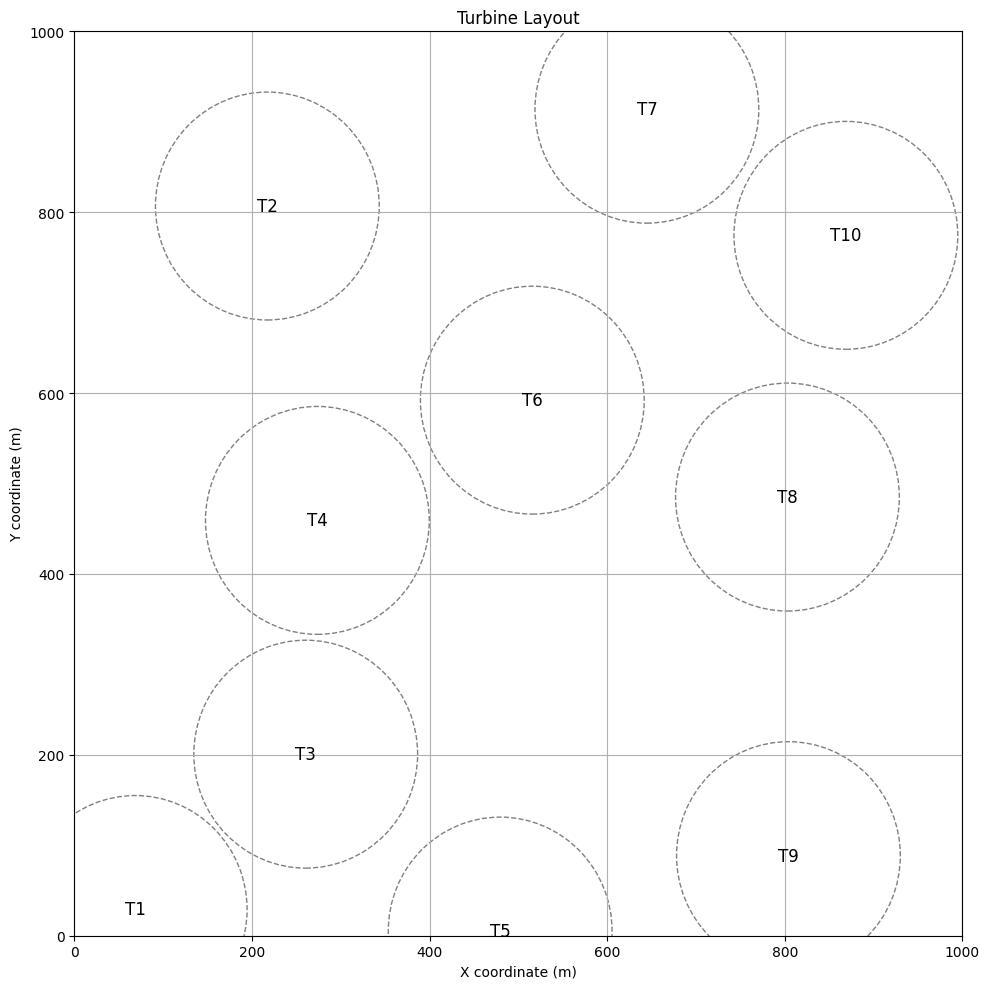

In [3]:
x0 = generate_valid_layout()
print("Valid layout generated:")
plot_layout(x0)

### Optimize layout

We will use basinhopping with SLSQP from Scipy to find an optimal layout. To help the solver, we will non-dimensionalize the problem to have inputs and outputs in the scale of [0,1].

Iter: 1 - New best AEP: 128.02 GWh - Improvement: 8.43%


floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
flor

Iter: 2 - New best AEP: 128.62 GWh - Improvement: 8.94%
Iter: 3 - Current AEP: 124.56 GWh - No improvement
Iter: 4 - Current AEP: 125.03 GWh - No improvement
Iter: 5 - Current AEP: 116.73 GWh - No improvement
Iter: 6 - Current AEP: 123.65 GWh - No improvement


floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
flor

Iter: 7 - Current AEP: 120.65 GWh - No improvement
Iter: 8 - Current AEP: 128.52 GWh - No improvement
Iter: 9 - Current AEP: 128.13 GWh - No improvement
Iter: 10 - Current AEP: 128.36 GWh - No improvement
Iter: 11 - Current AEP: 125.78 GWh - No improvement
Optimization completed with success: True
Number of basinhopping iterations: 10
Final AEP: 128.62 GWh
Improvement over initial layout: 8.94%


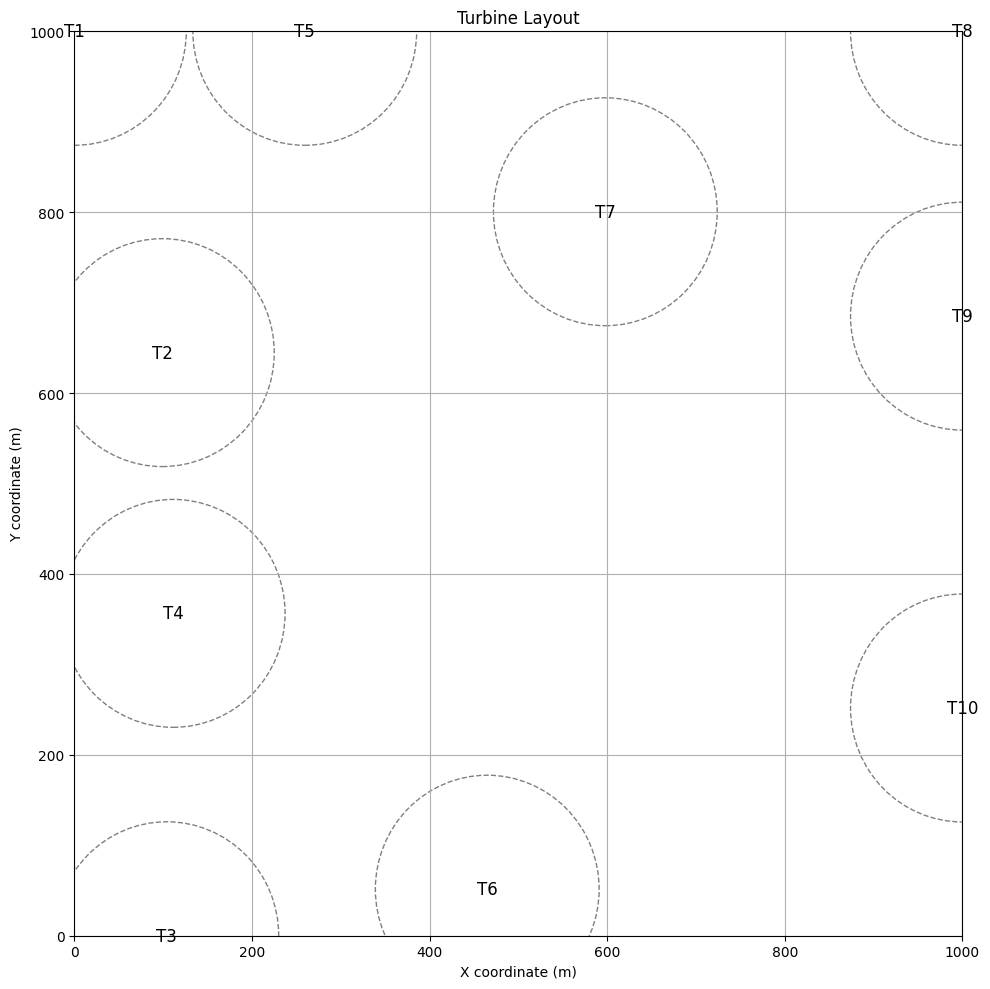

In [4]:
def optimize_layout(x0, n_turbines=10):
    # Bound size - we will scale the coordinates
    # by this factor before function evaluation
    L = 1000

    # Create the layout object
    layout = TurbineLayout(n_turbines=n_turbines)

    # Function to minimize (negative of AEP since we want to maximize)
    def objective(x_flat):
        x_reshaped = x_flat.reshape(n_turbines, 2)
        # Normalize by no wake AEP
        return -layout.evaluate(x_reshaped * L) / layout.aep_no_wake

    # Reshape constraints - basinhopping requires a flat array
    def dist_constraint_wrapper(x_flat):
        x_reshaped = x_flat.reshape(n_turbines, 2)
        return layout.dist_constraint(x_reshaped * L)

    def perm_constraint_wrapper(x_flat):
        x_reshaped = x_flat.reshape(n_turbines, 2)
        return layout.perm_constraint(x_reshaped * L)

    # Set up constraints for SLSQP
    constraints = [
        {'type': 'ineq', 'fun': dist_constraint_wrapper},
        {'type': 'ineq', 'fun': perm_constraint_wrapper}
    ]

    # Set up bounds for flattened x - scale to [0, 1] range
    bounds_list = np.asarray(layout.bounds()).reshape(-1, 2) / L

    # Callback function to track progress
    best_aep = layout.evaluate(x0 * L)
    iterations = 0

    def callback(x, f, accept):
        nonlocal best_aep
        nonlocal iterations
        current_x = x.reshape(n_turbines, 2)
        current_aep = layout.evaluate(current_x * L)

        if current_aep > best_aep:
            best_aep = current_aep
            iterations += 1
            print(f"Iter: {iterations} - New best AEP: {best_aep/1e9:.2f} GWh - Improvement: {(best_aep/layout.evaluate(x0 * L) - 1)*100:.2f}%")
        else:
            iterations += 1
            print(f"Iter: {iterations} - Current AEP: {current_aep/1e9:.2f} GWh - No improvement")

        return False  # Return False to continue optimization

    # Local minimizer
    minimizer_kwargs = {
        'method': 'SLSQP',
        'jac': "3-point",
        'bounds': bounds_list,
        'constraints': constraints
    }

    # Run basin hopping
    result = opt.basinhopping(
        objective,
        x0.flatten(),
        minimizer_kwargs=minimizer_kwargs,
        niter=10,
        seed=42,
        callback=callback
    )

    # Reshape the result back to (n_turbines, 2)
    x_opt = result.x.reshape(n_turbines, 2)

    # Calculate the AEP
    aep = layout.evaluate(x_opt * L)

    return x_opt, aep, result, layout.evaluate(x0 * L)

# Run the optimization
x_opt, aep, result, initial = optimize_layout( x0 / 1000 )

# Print optimization results
print(f"Optimization completed with success: {result.success}")
print(f"Number of basinhopping iterations: {result.nit}")
print(f"Final AEP: {aep/1e9:.2f} GWh")
print(f"Improvement over initial layout: {(aep/initial - 1)*100:.2f}%")

# Plot the optimized layout
plot_layout(x_opt * 1000)

## Benchmarking
---

Now that we see how these problems are structured, let's use them to benchmark a solver. The `n_dimensions` argument from `run_solvers` will be used as the number of turbines in the problem, making 20 and 30 dimensional problems.

In [ ]:
# Choose both turbine layout problems
problems = [TurbineLayout, TurbineLayoutYaw]
class BasinHopping(BaseOptimizer):
    deterministic = False
    n_points = 1

    def optimize(self, func, bounds, x0=None, constraints=None, **kwargs):
        minimizer_kwargs = {'bounds': bounds}
        result = opt.basinhopping(func, x0, minimizer_kwargs=minimizer_kwargs, **kwargs)
        return OptimizationResult(result.x, result.fun, algorithm=self.name)

solvers = [BasinHopping]

# Run the solvers on the problems
pygoblet.run_solvers(solvers, problems, test_dimensions=[10], n_iters=3, verbose=True)

# Post-process results
x = pygoblet.postprocessing.postprocess_data(["output_data/BasinHopping"])

/Users/bselvage/Library/CloudStorage/OneDrive-NREL/VSCode/global_opt_bench/pygoblet/runners.py:385: UserWarning: CodeCarbon is not available, energy tracking will not be performed.
  warnings.warn("CodeCarbon is not available, energy tracking will not be performed.")


Running BasinHopping on TurbineLayout with 10 turbines, 20 dimensions, iteration 1/3


floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
floris.floris_model.FlorisModel WARNING Some velocities at the rotor are negative.
flor

## Display Results
---


In [ ]:
# Path to the figures
figure_path = "ppfigures/"

# Get all figure files in the directory
figure_files = glob.glob(os.path.join(figure_path, "*.png"))
figure_files.sort()

# Display each figure
for fig_file in figure_files:
    plt.figure(figsize=(10, 8))
    img = plt.imread(fig_file)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Display dataframe
display(Markdown("## Average fevals per problem among successful runs:"))
display(x['data'])